In [1]:
import pysm3
import pysm3.units as u
import astropy.io.fits as fits

import healpy as hp
from fgbuster import (CMB, Dust, Synchrotron,
                      basic_comp_sep,
                      get_observation, get_noise_realization, get_instrument, get_sky)
from fgbuster.visualization import corner_norm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

### Variable from "Patch_create" 

In [2]:
nside    = 4096
pix_size = 0.8588716029543515 #arcmin

Nx = 600
Ny = 800

X_width = Nx * pix_size/60
Y_width = Ny * pix_size/60

# color map
c_min, c_max     = -10, 10      


print(f"Patch con {Nx} x {Ny} pixels, ognuno di {pix_size} arcmin, per una dimensione totale di {X_width:.2f} x {Y_width:.2f} gradi")

Patch con 600 x 800 pixels, ognuno di 0.8588716029543515 arcmin, per una dimensione totale di 8.59 x 11.45 gradi


### Leggo i dati

In [3]:
I_patch = fits.getdata("I_patch")
Q_patch = fits.getdata("Q_patch")
U_patch = fits.getdata("U_patch")

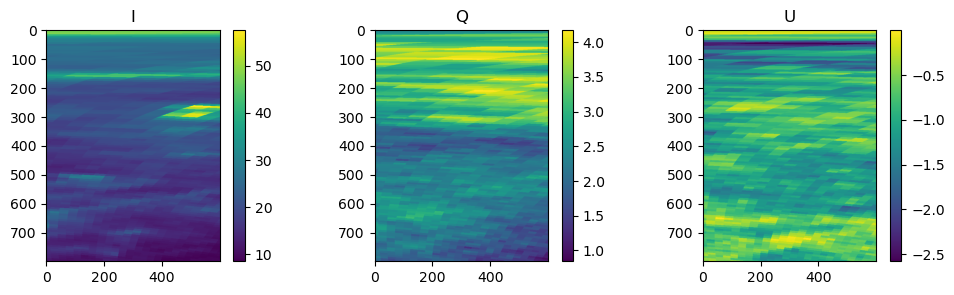

In [4]:
maps = [I_patch, Q_patch, U_patch]
title = ['I', 'Q', 'U']

# Visualizza le mappe in una griglia 2x2
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for i in range(3):
        im =axs[i].imshow(maps[i], cmap='viridis')  # cmap è la mappa di colori, puoi cambiare in base alle tue preferenze
        axs[i].set_title(title[i])
        cbar = fig.colorbar(im, ax=axs[i])#, aspect=5)

plt.show()

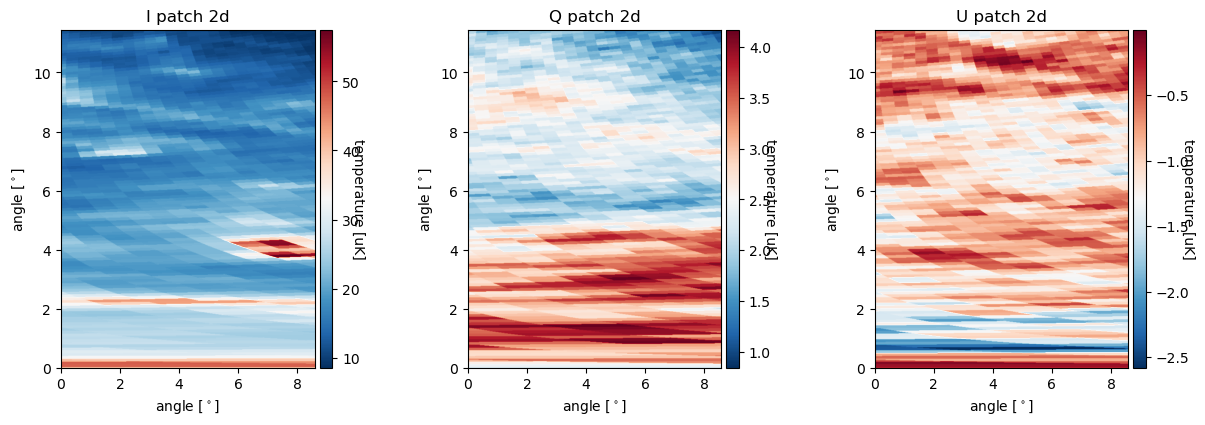

In [5]:
# PLOT

Map_to_Plot = [I_patch, Q_patch, U_patch]
title = ["I patch 2d","Q patch 2d","U patch 2d"]
c_factor_max = [np.max(I_patch), np.max(Q_patch), np.max(U_patch)]
c_factor_min = [np.min(I_patch), np.min(Q_patch), np.min(U_patch)]

fig, axs = plt.subplots(1, 3, figsize=(14, 8))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_max, c_factor_iter_min) in enumerate(zip(Map_to_Plot, c_factor_max, c_factor_min)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

#plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.2, top=0.90)
#plt.suptitle('Maps convolution with beam', fontsize=20)
plt.show()

# Analisi

### BEAM

ellipticity =  -0.3333333333333333


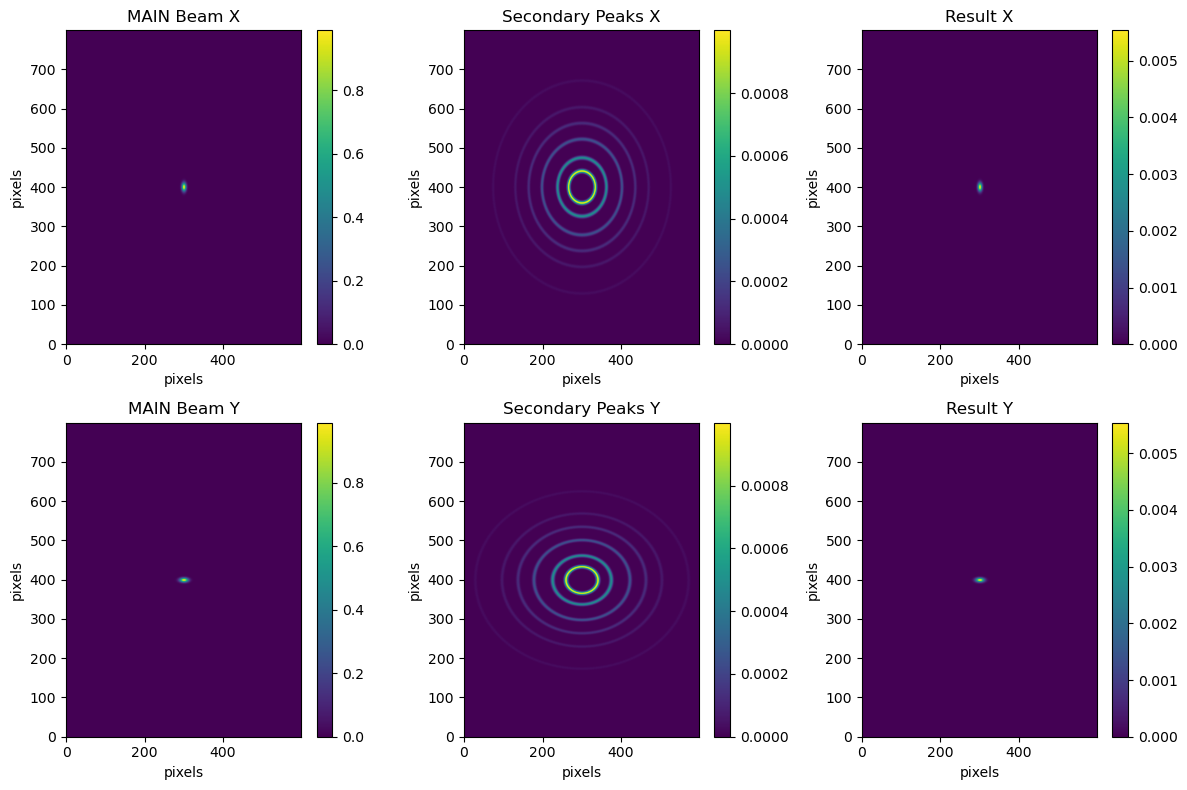

In [6]:
# COORDINATES LIKE THE ONES OF THE MAPS

Nx = int(Nx)
Ny = int(Ny)

onesx = np.ones(Nx)
onesy = np.ones(Ny)

indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

X = np.outer(onesy, indsx)
Y = np.outer(indsy, onesx)
R = np.sqrt(X**2. + Y**2.)


#####################################################################################

# VARIABLES

FWHM_x = 15  #degrees
FWHM_y = 30  #degrees
ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)

array_dB = np.array([-20, -22,  -24, -26, -28, -30])  #max values of the secondary peaks
array_dB = array_dB * 1.5
r1 = np.array([30, 55, 90, 120, 150, 200]) #angular distance of the peaks
r = 4 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 


#########################################################################################

# BEAM

beam_gauss_x, beam_gauss_y, sec_rings_x,sec_rings_y, beam_x, beam_y = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, theta, array_dB, r, r1, X, Y, a, ellipticity)

########################################################################################

# PLOT

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
titles = ['MAIN Beam X', 'Secondary Peaks X', 'Result X', 'MAIN Beam Y', 'Secondary Peaks Y', 'Result Y']
data_list = [beam_gauss_x, sec_rings_x, beam_x, beam_gauss_y, sec_rings_y, beam_y]

for i, ax in enumerate(axes.flat):
    im = ax.imshow(data_list[i], cmap='viridis', origin='lower')
    ax.set_title(titles[i])
    ax.set_xlabel('pixels')
    ax.set_ylabel('pixels')
    cbar = plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [7]:
'''
def Plot_beam_rectangular(beam_to_Plot,c_min,c_max, X_width, Y_width,title, axis):
    print("beam max:",np.max(beam_to_Plot),"beam min:",np.std(beam_to_Plot))
   
    plt.figure(figsize=(4, 4))
    im = plt.imshow(beam_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.magma)
    im.set_clim(c_min,c_max)
    cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel(axis)
    plt.xlabel(axis)
    cbar.set_label('amplitud (arb)', rotation=270)
    plt.title(title)
    #plt.show()
    return(0)
'''

'\ndef Plot_beam_rectangular(beam_to_Plot,c_min,c_max, X_width, Y_width,title, axis):\n    print("beam max:",np.max(beam_to_Plot),"beam min:",np.std(beam_to_Plot))\n   \n    plt.figure(figsize=(4, 4))\n    im = plt.imshow(beam_to_Plot, interpolation=\'bilinear\', origin=\'lower\',cmap=cm.magma)\n    im.set_clim(c_min,c_max)\n    cbar = plt.colorbar()\n    im.set_extent([0,X_width,0,Y_width])\n    plt.ylabel(axis)\n    plt.xlabel(axis)\n    cbar.set_label(\'amplitud (arb)\', rotation=270)\n    plt.title(title)\n    #plt.show()\n    return(0)\n'

beam max: 4.342923104481638e-05 beam min: 3.4852325694415813
beam max: 4.342923104481638e-05 beam min: 3.4852325694415818


0

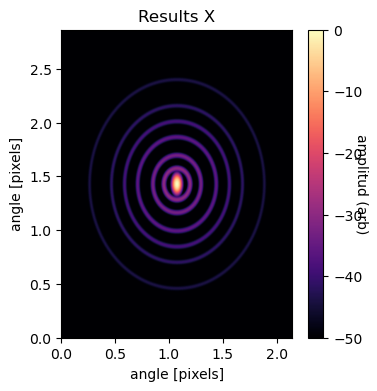

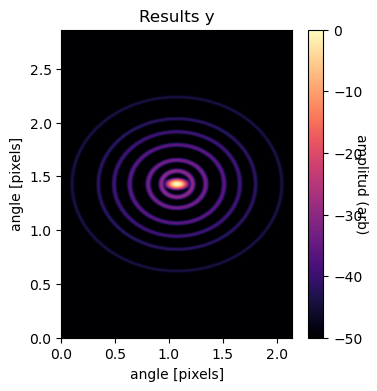

In [8]:
beam_to_plot = beam_x
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/4, Y_width/4, "Results X", "angle [pixels]")

beam_to_plot = beam_y
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/4, Y_width/4, "Results y", "angle [pixels]")

In [9]:
### beam systematics dictionary
bs = {"budy":{"A":1e-3,"FWHP":1.5,"R":70.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-4,"Diam":20.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 2.5,"N":5,"neighbor_exp_fall":0.01}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

In [10]:
'''
def make_2d_beam_cordinates_r(Nx, Ny, pix_size):
    # make a 2d coordinate system
    onesx = np.ones(Nx)
    onesy = np.ones(Ny)
    
    indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
    indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size
    
    X = np.outer(onesy, indsx)
    Y = np.outer(indsy, onesx)
    
    R = np.sqrt(X**2. + Y**2.)
    Theta = np.arctan2(Y,X)
    return(X,Y,R,Theta)


def make_little_buddies_r(Nx, Ny,pix_size,beam_size_fwhp,bs,main_beam_peak):
    # make a 2d coordinate system
    X,Y,R,Theta = make_2d_beam_cordinates_r(Nx, Ny,pix_size)
    #set up four buddies
    budy_sigma = bs["budy"]["FWHP"] / np.sqrt(8.*np.log(2))
    X_rot = X * np.cos(bs["budy"]["psi"]) - Y*np.sin(bs["budy"]["psi"])
    Y_rot = X * np.sin(bs["budy"]["psi"]) + Y*np.cos(bs["budy"]["psi"])
    buddy_beam = 0.
    R_temp = np.sqrt((X_rot - bs["budy"]["R"])**2. + Y_rot**2.)
    buddy_beam+= np.exp(-.5 *(R_temp/budy_sigma)**2.)
    R_temp = np.sqrt((X_rot + bs["budy"]["R"])**2. + Y_rot**2.)
    buddy_beam+= np.exp(-.5 *(R_temp/budy_sigma)**2.)
    R_temp = np.sqrt(X_rot**2. + (Y_rot - bs["budy"]["R"])**2.)
    buddy_beam+= np.exp(-.5 *(R_temp/budy_sigma)**2.)
    R_temp = np.sqrt(X_rot**2. + (Y_rot + bs["budy"]["R"])**2.)
    buddy_beam+= np.exp(-.5 *(R_temp/budy_sigma)**2.)
    buddy_beam = buddy_beam / np.max(buddy_beam)   ##  normalize the budy beam to 1
    ## make the buddy beams
    Budy_TT = buddy_beam / np.max(buddy_beam) * main_beam_peak * bs["budy"]["A"]  ## guarentees the budies are peak normalized realative to main beam
    Budy_QT = buddy_beam / np.max(buddy_beam) * main_beam_peak * bs["budy"]["A"] * bs["budy"]["polfracQ"]
    Budy_UT = buddy_beam / np.max(buddy_beam) * main_beam_peak * bs["budy"]["A"] * bs["budy"]["polfracU"]
    ## return the buddies
    return(Budy_TT,Budy_QT,Budy_UT)


def make_ghosting_beam_r(Nx, Ny,pix_size,beam_size_fwhp,bs,main_beam_peak):
    # make a 2d coordinate system
    X,Y,R,Theta = make_2d_beam_cordinates_r(Nx, Ny,pix_size)
    ## make shelf
    in_shelf = np.where(R < bs["ghostshelf"]["Diam"])
    shelf = np.zeros(np.shape(R))
    shelf[in_shelf] = 1.
    roll_off_kernal = np.exp(-.5 *(R/bs["ghostshelf"]["roll_off"])**2.)
    shelf = convlolve(shelf,roll_off_kernal)
    shelf = shelf / np.max(shelf) * main_beam_peak * bs["ghostshelf"]["A"]  ## normalized relative to the peak of the main beam
    return(shelf)



def make_cross_talk_beam_grid_r(Nx, Ny, pix_size, beam_size_fwhp, bs):
    # make a 2d coordinate system
    X, Y, R, Theta = make_2d_beam_cordinates_r(Nx, Ny ,pix_size)

    ## make cross-talk grid
    hex_grid = np.zeros((Ny, Nx))  # Modifica la forma in base a Nx e Ny

    delta_Ny = np.floor(bs["hex_crostalk"]["grid_space"] / pix_size)
    delta_Ny_nextrow = delta_Ny / 2.
    delta_Nx_nextrow = delta_Ny * np.cos(30. * np.pi / 180.)

    i = -1 * bs["hex_crostalk"]["N"]
    while (i <= bs["hex_crostalk"]["N"]):
        j = -1 * bs["hex_crostalk"]["N"]
        while (j <= bs["hex_crostalk"]["N"]):
            i_active = Ny / 2 + i * delta_Ny
            j_active = Nx / 2 + j * delta_Nx_nextrow
            if (i % 2 == 1):
                j_active -= delta_Ny_nextrow  ## offset every other row
            i_active = int(i_active)
            j_active = int(j_active)
            if ((i_active != Ny / 2) or (j_active != Nx / 2)):  # exclude the main beam
                distance = np.sqrt(np.abs((i_active - Ny / 2) / delta_Ny) ** 2 + np.abs(
                    (j_active - Nx / 2) / delta_Ny) ** 2)
                xtalk_tau = 1. / np.log(bs["hex_crostalk"]["neighbor_exp_fall"])
                distance /= xtalk_tau
                hex_grid[i_active, j_active] = np.exp(distance)
            j += 1
        i += 1

    const = np.ones(np.shape(hex_grid))
    hex_grid *= np.sum(const)  ## normalize the gain so that the x-talk amplitude is defined correclty
    return hex_grid






def make_systematics_beams_r(Nx, Ny,pix_size,beam_size_fwhp, beam,bs):
    
        # intitalize the beam to zero
        B_TT=B_QQ=B_UU=B_QT=B_UT=B_QU=B_UQ=0.
    
        ## merge this into the beam
        B_TT += beam
        B_QQ += beam
        B_UU += beam
    
        beam_peak = np.max(beam)
    
        # make the little buddies
        Budy_TT,Budy_QT,Budy_UT = make_little_buddies_r(Nx, Ny,pix_size,beam_size_fwhp,bs,beam_peak)
        ## merge this into the beam
        B_TT += Budy_TT
        B_QT += Budy_QT
        B_UT += Budy_UT

        # make the ghosting shelf
        shelf = make_ghosting_beam_r(Nx, Ny,pix_size,beam_size_fwhp,bs,beam_peak)
        ## merge this into the beam
        B_TT += shelf
        B_QQ += shelf
        B_UU += shelf
    
        # make the cross talk beam
        # make a hex grid centered on the beam
        hex_grid = make_cross_talk_beam_grid_r(Nx,Ny,pix_size,beam_size_fwhp,bs)
        #convolve the hex grid with the beam
        cross_talk = convlolve(hex_grid,beam)
        ## merge this into the beam
        B_TT += cross_talk
        B_QQ += cross_talk
        B_UU += cross_talk
        B_QT += cross_talk
        B_UT += cross_talk
    
        
        ## add the monopole + dipole + quadrupole T->P leakages
        # make the beam modes
        #mono,dip_x,dip_y,quad_x,quad_45 = make_monopole_dipole_quadrupole(N,pix_size,beam_size_fwhp,bs)
        #TtoQ = bs["TtoQ"]["mono"] * mono
        #TtoQ += bs["TtoQ"]["dip_x"] * dip_x
        #TtoQ += bs["TtoQ"]["dip_y"] * dip_y
        #TtoQ += bs["TtoQ"]["quad_x"] * quad_x
        #TtoQ += bs["TtoQ"]["quad_45"] * quad_45
        #TtoU = bs["TtoU"]["mono"] * mono
        #TtoU += bs["TtoU"]["dip_x"] * dip_x
        #TtoU += bs["TtoU"]["dip_y"] * dip_y
        #TtoU += bs["TtoU"]["quad_x"] * quad_x
        #TtoU += bs["TtoU"]["quad_45"] * quad_45
        ## add to the beams
        #B_QT += TtoQ
        #B_UT += TtoU
        
    
        return(B_TT,B_QQ,B_UU,B_QT,B_UT,B_QU,B_UQ)  
        
'''

'\ndef make_2d_beam_cordinates_r(Nx, Ny, pix_size):\n    # make a 2d coordinate system\n    onesx = np.ones(Nx)\n    onesy = np.ones(Ny)\n    \n    indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size\n    indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size\n    \n    X = np.outer(onesy, indsx)\n    Y = np.outer(indsy, onesx)\n    \n    R = np.sqrt(X**2. + Y**2.)\n    Theta = np.arctan2(Y,X)\n    return(X,Y,R,Theta)\n\n\ndef make_little_buddies_r(Nx, Ny,pix_size,beam_size_fwhp,bs,main_beam_peak):\n    # make a 2d coordinate system\n    X,Y,R,Theta = make_2d_beam_cordinates_r(Nx, Ny,pix_size)\n    #set up four buddies\n    budy_sigma = bs["budy"]["FWHP"] / np.sqrt(8.*np.log(2))\n    X_rot = X * np.cos(bs["budy"]["psi"]) - Y*np.sin(bs["budy"]["psi"])\n    Y_rot = X * np.sin(bs["budy"]["psi"]) + Y*np.cos(bs["budy"]["psi"])\n    buddy_beam = 0.\n    R_temp = np.sqrt((X_rot - bs["budy"]["R"])**2. + Y_rot**2.)\n    buddy_beam+= np.exp(-.5 *(R_temp/budy_sigma)**2.)\n    R_temp = np.sqrt((X_rot + bs["budy"

beam max: 4.342923104481638e-05 beam min: 3.5103783280794802
beam max: 4.342923104481638e-05 beam min: 3.507934261854309
beam max: 4.342923104481638e-05 beam min: 3.507934261854309
beam max: 4.342923104481638e-05 beam min: 3.5504106555603205
beam max: 4.342923104481638e-05 beam min: 3.5454891340517096


0

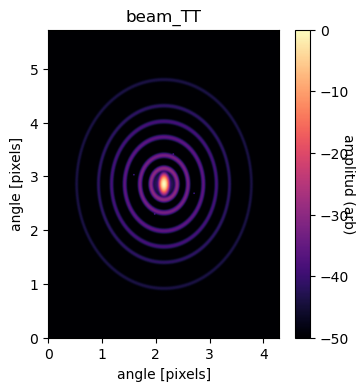

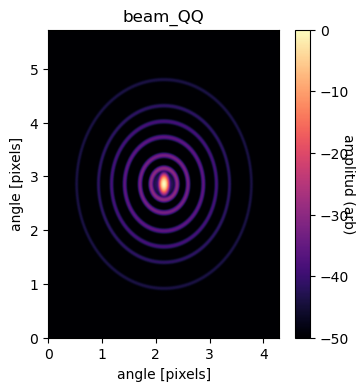

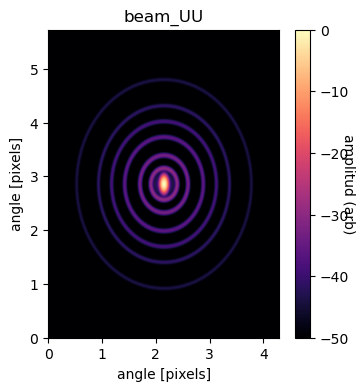

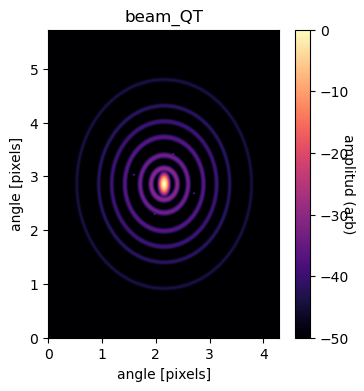

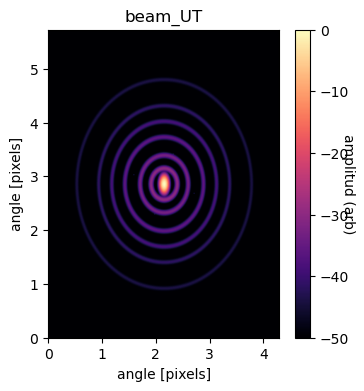

In [11]:
beam_sys = BeamSystematics()
beam_TT, beam_QQ, beam_UU, beam_QT, beam_UT, beam_QU, beam_UQ = make_systematics_beams_r(Nx, Ny, pix_size, FWHM_x, beam_x, bs)


######################################################################################################################################
beam_to_plot = beam_TT
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/2, Y_width/2,  "beam_TT", 'angle [pixels]')

beam_to_plot = beam_QQ
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/2, Y_width/2, "beam_QQ", 'angle [pixels]')
                                                            
beam_to_plot = beam_UU
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/2, Y_width/2,"beam_UU", 'angle [pixels]')


beam_to_plot = beam_QT
if np.any(beam_to_plot <= 0):
    beam_to_plot[beam_to_plot <= 0] = 1e-21
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/2, Y_width/2, "beam_QT", 'angle [pixels]')

beam_to_plot = beam_UT
beam_to_plot = beam_to_plot / np.max(beam_to_plot) + 1e-5
if np.any(beam_to_plot <= 0):
    beam_to_plot[beam_to_plot <= 0] = 1e-21
beam_to_plot = 10. * np.log10(beam_to_plot)
Plot_beam_rectangular(beam_to_plot,np.min(beam_to_plot),np.max(beam_to_plot),X_width/2, Y_width/2, "beam_UT", 'angle [pixels]')

In [12]:
# convolution with perfect beam
perf_beam, no1, no2, no3, no4, no5 = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, 0, array_dB, r, r1, X, Y, a, ellipticity)
perf_beam = perf_beam / np.sum(perf_beam)

Q_conv_perf = convolve_map_with_beam(Q_patch, perf_beam)
U_conv_perf = convolve_map_with_beam(U_patch, perf_beam)


# convolution with real beam
I_conv_real = convolve_map_with_beam(I_patch, beam_TT)
Q_conv_real = convolve_map_with_beam(Q_patch, beam_QQ)
U_conv_real = convolve_map_with_beam(U_patch, beam_UU)

## Polarization angle

In [13]:
std_deviation_degree = 1
std_deviation_rad= std_deviation_degree * np.pi / 180
gauss_center  = 0

print(std_deviation_rad)

0.017453292519943295


In [15]:
'''
def cosine_window_r(Nx, Ny):
    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" 
    # make a 2d coordinate system

    Nx = int(Nx)
    Ny = int(Ny)

    onesx = np.ones(Nx)
    onesy = np.ones(Ny)

    indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
    indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

    X = np.outer(onesy, indsx)
    Y = np.outer(indsy, onesx)

    # make a window map
    window_map = np.cos(X) * np.cos(Y)
   
    # return the window map
    return(window_map)

'\ndef cosine_window_r(Nx, Ny):\n    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" \n    # make a 2d coordinate system\n\n    Nx = int(Nx)\n    Ny = int(Ny)\n\n    onesx = np.ones(Nx)\n    onesy = np.ones(Ny)\n\n    indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size\n    indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size\n\n    X = np.outer(onesy, indsx)\n    Y = np.outer(indsy, onesx)\n\n    # make a window map\n    window_map = np.cos(X) * np.cos(Y)\n   \n    # return the window map\n    return(window_map)\n'

In [16]:
# POLARIZATION ANGLE
 
Q_pert, U_pert = polangle_map(Q_conv_real, U_conv_real, gauss_center, std_deviation_rad)
#Q_map_pert_perf, U_map_pert_perf = polangle_map(Q_conv_perf, U_conv_perf, gauss_center, std_deviation_rad)

########################################################################################################

# APODIZATION
window = (cosine_window_r(Nx, Ny, pix_size))
Q_ap = window * Q_pert
U_ap = window * U_pert

########################################################################################################

# plot
Map_to_Plot = [Q_patch, Q_conv_real,Q_pert,Q_ap, U_patch, U_conv_real ,U_pert, U_ap]
title = ["Q original","Q convolved","Q conv+pol_angle", "Q conv+pol_angle+ap", "U original","U convolved", "U conv+pol_angle", "U conv+pol_angle+ap"]
c_factor_max = [np.max(Q_patch), np.max(Q_conv_real), np.max(Q_pert), np.max(Q_ap), np.max(U_patch), np.max(U_conv_real), np.max(U_pert), np.max(U_ap)]
c_factor_min = [np.min(Q_patch), np.min(Q_conv_real), np.min(Q_pert), np.min(Q_ap), np.min(U_patch), np.min(U_conv_real), np.min(U_pert), np.min(U_ap)]

fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Maps convolved with beam and with polarization angle systematics added', fontsize=20)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelPerturbation.png')
plt.show()


TypeError: cosine_window_r() takes 2 positional arguments but 3 were given

## Deconvolution

In [28]:
'''
def correct_lr_r(map, init_beam,Nx, Ny, pix_size, mode='onestep',pad = None, filter_eps=1e-10, eps=1e-12, post_f=None, iter=50):
    from copy import deepcopy
    # GET MAP PARAMETERS 
    Nx = int(Nx)
    Ny = int(Ny)

    onesx = np.ones(Nx)
    onesy = np.ones(Ny)

    indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
    indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

    X = np.outer(onesy, indsx)
    Y = np.outer(indsy, onesx)
    r = np.sqrt(X**2. + Y**2.)
    
    
    
    #shape = [4*(aMap.MAP.shape[0]+1)-1, 4*(aMap.MAP.shape[1]+1)-1]
    #init_bmap, r = init_beam.return_bMap(pixscale=pixscale,shape=[811,811],rad=True, oversamp=1)
    init_bmap = map
    
    init_bmap = 10**(init_bmap/10) * merge_cosine(r, center = 345, width=40)
    init_bmap /= np.nanmax(init_bmap)
  
    init_bmap = init_bmap / np.nanmax(init_bmap)

    init_bmap[init_bmap<0] = 0.
    
    # DECONVOLVE
    if mode=='onestep':
        psf_ = init_bmap / np.nansum(init_bmap)
        dat_ = deepcopy(map)
        if pad!=None:
            pad_pix = int(pad*np.max(np.shape(dat_)))
            new = np.ones([np.shape(dat_)[0]+(2*pad_pix), np.shape(dat_)[1]+(2*pad_pix)])*np.nanmedian(dat_)
            new[pad_pix:-pad_pix, pad_pix:-pad_pix] = dat_
            dat_ = new
        map_ = deepcopy(dat_)
        if iter==None:
            SNAPSHOTS = np.array([0,10,20,30,40,50])
        else:
            SNAPSHOTS = np.array([0,int(iter)])
        
        allframes = np.zeros([np.nanmax(SNAPSHOTS)+1,np.shape(dat_)[0],np.shape(dat_)[1]])
        frames = np.zeros([len(SNAPSHOTS),np.shape(dat_)[0],np.shape(dat_)[1]])
        frames[0] = map_
        allframes[0] = map_
        
        n_iter = 0
        i = 1
        
    return map_


'''

In [29]:
Q_deconv = correct_lr_r(Q_ap/window, perf_beam,Nx, Ny, pix_size, 'onestep', None, 1e-10, 1e-12, None, 50)
U_deconv = correct_lr_r(U_ap/window, perf_beam,Nx, Ny, pix_size, 'onestep', None, 1e-10, 1e-12, None, 50)
I_deconv = correct_lr_r(I_conv_real, perf_beam,Nx, Ny, pix_size, 'onestep', None, 1e-10, 1e-12, None, 50)

In [30]:
# DIFFERENCE
Q_diff = (Q_conv_perf- Q_deconv)
U_diff = (U_conv_perf- U_deconv)

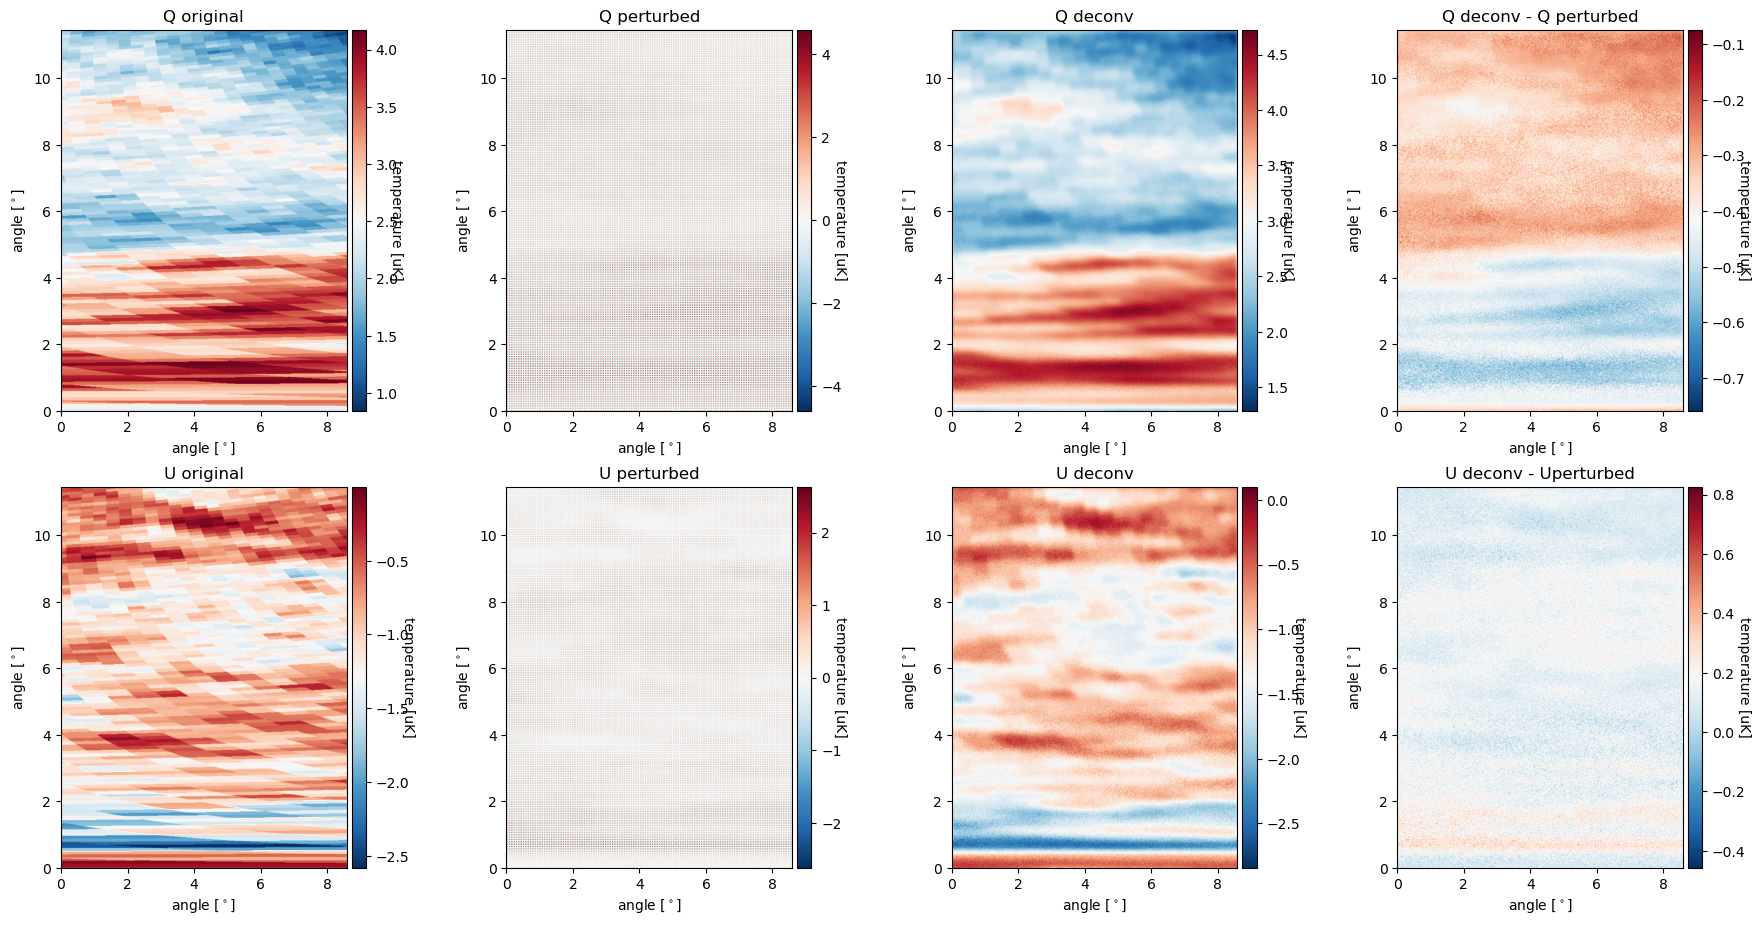

In [31]:
Map_to_Plot = [Q_patch,Q_ap, Q_deconv, Q_diff, U_patch, U_ap, U_deconv, U_diff]
title = ["Q original", "Q perturbed", "Q deconv", "Q deconv - Q perturbed", "U original","U perturbed", "U deconv", "U deconv - Uperturbed"]
c_factor_max = [np.max(Q_patch), np.max(Q_ap), np.max(Q_deconv), np.max(Q_diff), np.max(U_patch), np.max(U_ap), np.max(U_deconv), np.max(U_diff)]
c_factor_min = [np.min(Q_patch), np.min(Q_ap), np.min(Q_deconv), np.min(Q_diff), np.min(U_patch), np.min(U_ap), np.min(U_deconv), np.min(U_diff)]

fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
#plt.suptitle('Maps convolved with beam and with polarization angle systematics added', fontsize=20)
plt.show()


In [32]:
def QU2EB_r(Nx, Ny,pix_size,Qmap,Umap,):
    '''Calcalute E, B maps given input Stokes Q, U maps'''


    # Create 2d Fourier coordinate system.
    onesx = np.ones(Nx)
    onesy = np.ones(Ny)
    indsx  = (np.arange(Nx) - Nx/2.) /(Nx-1.)
    indsy  = (np.arange(Ny) - Ny/2.) /(Ny-1.)

    
    kX = np.outer(onesy,indsx) / (pix_size/60. * np.pi/180.)
    kY = np.outer(indsy, onesx) / (pix_size/60. * np.pi/180.)
    
    ang = np.arctan2(kY,kX)
 
    # Convert to Fourier domain.
    fQ = np.fft.fftshift(np.fft.fft2(Qmap))
    fU = np.fft.fftshift(np.fft.fft2(Umap))
    
    # Convert Q, U to E, B in Fourier domain.
    fE = fQ * np.cos(2.*ang) + fU * np.sin(2. *ang)
    fB = - fQ * np.sin(2.*ang) + fU * np.cos(2. *ang)
    
    # Convert E, B from Fourier to real space.
    Emap = np.real(np.fft.ifft2(np.fft.fftshift(fE)))
    Bmap = np.real(np.fft.ifft2(np.fft.fftshift(fB)))

    return Emap, Bmap

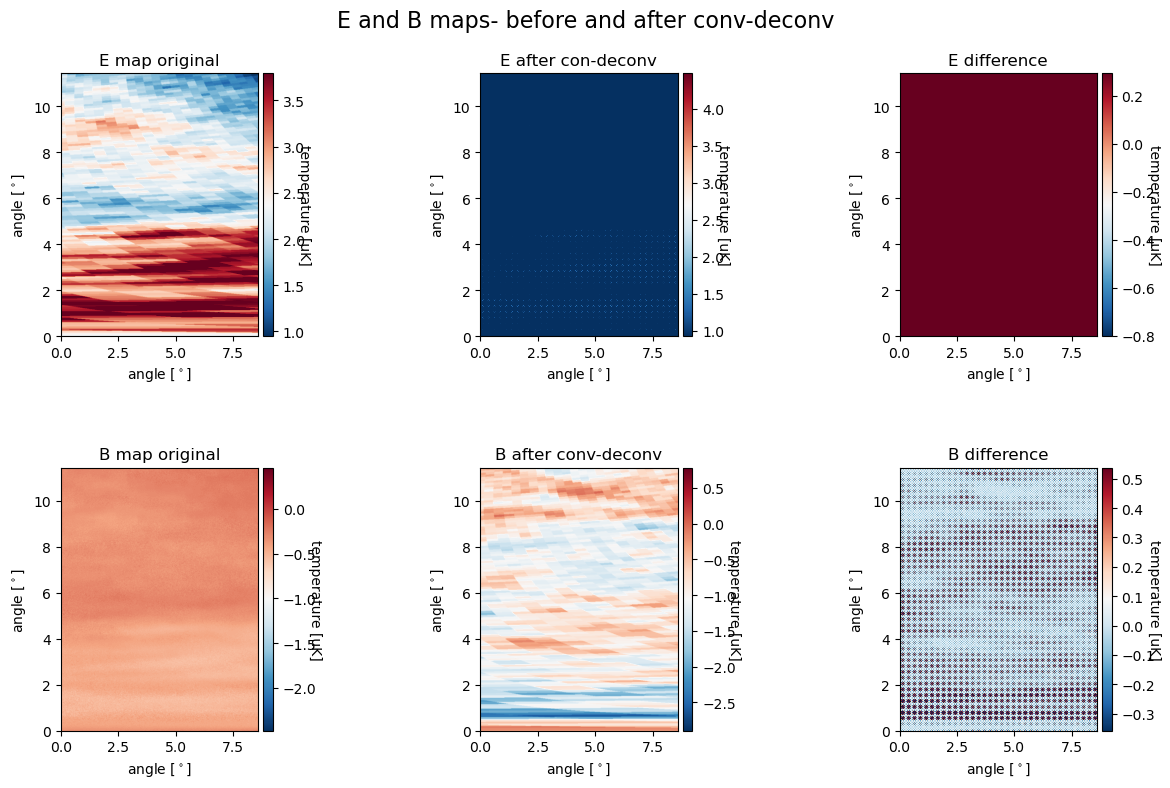

In [34]:
# FROM QU TO EB (beam + pol_angle)
E_deconv, B_deconv = QU2EB_r(Nx, Ny,pix_size,Q_deconv,U_deconv)

E_diff, B_diff     = QU2EB_r(Nx, Ny,pix_size,Q_diff,U_diff)

E_conv, B_conv     = QU2EB_r(Nx, Ny,pix_size,Q_conv_perf,U_conv_perf)

#E_conv = convolve_map_with_beam(E_map, perf_beam)
#B_conv = convolve_map_with_beam(B_map, perf_beam)



map_list      = [E_conv, E_deconv, E_diff, B_conv, B_deconv, B_diff] 
title_list    = ["E map original", "E after con-deconv", "E difference", "B map original", "B after conv-deconv", "B difference"]
c_factor_max = [np.max(E_conv), np.max(E_deconv), np.max(E_diff), np.max(B_conv), np.max(B_deconv), np.max(B_diff)]
c_factor_min = [np.min(E_conv), np.min(E_deconv), np.min(E_diff), np.min(B_conv), np.min(B_deconv), np.min(B_diff)]


fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs      = axs.flatten()

for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title_list[i])
        
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.90)
plt.suptitle('E and B maps- before and after conv-deconv', fontsize=16)
plt.show()

In [35]:
'''
def calculate_2d_spectrum_r(Map1,Map2,delta_ell,ell_max,pix_size,Nx, Ny):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
     # Create 2d Fourier coordinate system.
  
    
    Nx = int(Nx)
    Ny = int(Ny)
    # make a 2d ell coordinate system
    onesx = np.ones(Nx)
    onesy = np.ones(Ny)
    indsx  = (np.arange(Nx) - Nx/2.) /(Nx-1.)
    indsy  = (np.arange(Ny) - Ny/2.) /(Ny-1.)
    
    kX = np.outer(onesy,indsx) / (pix_size/60. * np.pi/180.)
    kY = np.outer(indsy, onesx) / (pix_size/60. * np.pi/180.)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins    = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array  = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)
'''

In [36]:
delta_l = 50.
l_max   = 2500

# Power spectra deconvolved maps
binned_l_E_deconv, binned_spectrum_E_deconv = calculate_2d_spectrum_r(E_deconv,E_deconv,delta_l,l_max,pix_size,Nx, Ny)
binned_l_B_deconv, binned_spectrum_B_deconv = calculate_2d_spectrum_r(B_deconv,B_deconv,delta_l,l_max,pix_size,Nx, Ny)

# Power spectra difference maps - to obtain the side lobes
binned_l_Ediff, binned_spectrum_Ediff = calculate_2d_spectrum_r(E_diff,E_diff,delta_l,l_max,pix_size,Nx, Ny)
binned_l_Bdiff, binned_spectrum_Bdiff = calculate_2d_spectrum_r(B_diff,B_diff,delta_l,l_max,pix_size,Nx, Ny)

# Power spectra of maps convolved with a perfect beam to compare better with the deconvolved power spectra
binned_l_E_conv, binned_spectrum_E_conv = calculate_2d_spectrum_r(E_conv,E_conv,delta_l,l_max,pix_size,Nx, Ny)
binned_l_B_conv, binned_spectrum_B_conv = calculate_2d_spectrum_r(B_conv,B_conv,delta_l,l_max,pix_size,Nx, Ny)

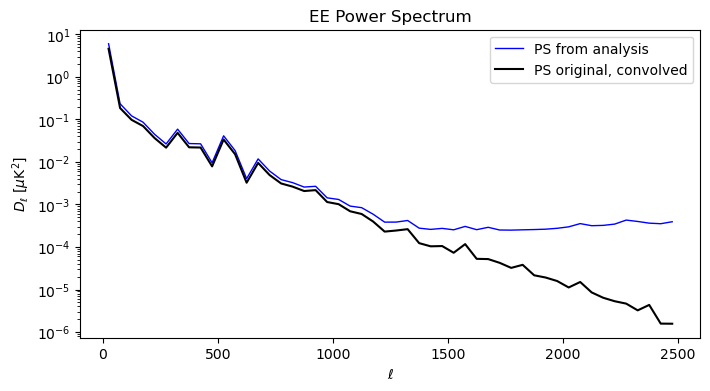

In [37]:
# EE
plt.figure(figsize=(8, 4))

# PS originale da camb
#plt.semilogy(ls,Original_PS[2], label="PS original", c="r", linewidth=1)

# PS dalle mappe convolute - deconvolute con beam con sistematiche
plt.semilogy(binned_l_E_deconv, binned_spectrum_E_deconv* binned_l_E_deconv * (binned_l_E_deconv+1.)/2. / np.pi,color='b', linewidth =1,label="PS from analysis")

# PS da mappe quasi originali, perchè convolute con un beam perfetto
plt.semilogy(binned_l_E_conv, binned_spectrum_E_conv* binned_l_E_conv * (binned_l_E_conv+1.)/2. / np.pi,color='black', label="PS original, convolved")




plt.title("EE Power Spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelEPS.png')
plt.show()

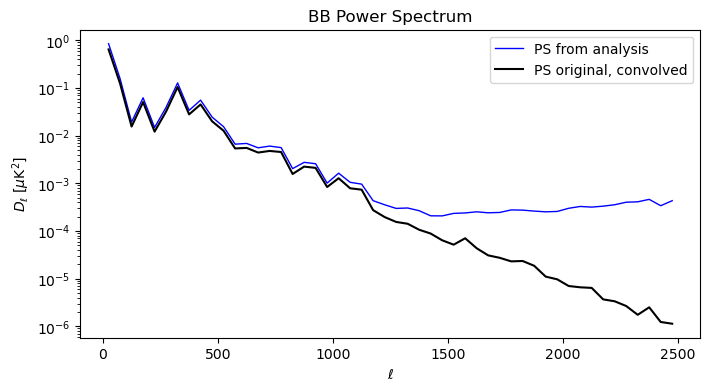

In [38]:
# BB
plt.figure(figsize=(8, 4))

# PS originale da camb
#plt.semilogy(ls,Original_PS[3], label="PS original", c="r", linewidth=1)

# PS dalle mappe convolute - deconvolute con beam con sistematiche
plt.semilogy(binned_l_B_deconv, binned_spectrum_B_deconv* binned_l_B_deconv * (binned_l_B_deconv+1.)/2. / np.pi,color='b', linewidth =1,label="PS from analysis")

# PS da mappe quasi originali, perchè convolute con un beam perfetto
plt.semilogy(binned_l_B_conv, binned_spectrum_B_conv* binned_l_B_conv * (binned_l_B_conv+1.)/2. / np.pi,color='black', label="PS original, convolved")



plt.title("BB Power Spectrum")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelBPS.png')
plt.show()

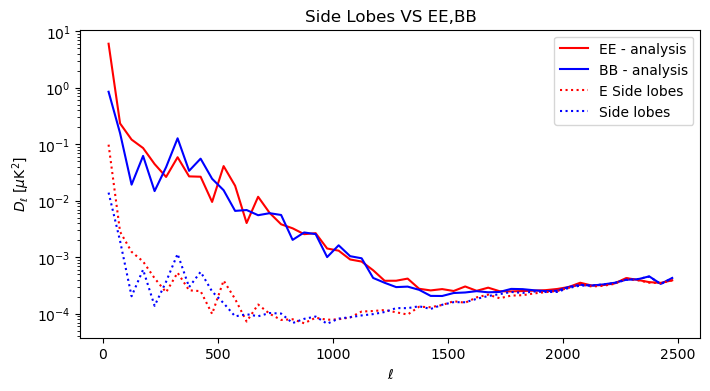

In [39]:
plt.figure(figsize=(8, 4))

# EE
#plt.semilogy(ls,Original_PS[2], label="EE - original", c="r", linewidth=1)
plt.semilogy(binned_l_E_deconv, binned_spectrum_E_deconv* binned_l_E_deconv * (binned_l_E_deconv+1.)/2. / np.pi,color='r',label="EE - analysis")

#BB
#plt.semilogy(ls,Original_PS[3], label="BB - original", c="b", linewidth=1)
plt.semilogy(binned_l_B_deconv, binned_spectrum_B_deconv* binned_l_B_deconv * (binned_l_B_deconv+1.)/2. / np.pi,color='b', label="BB - analysis")

# SIDE LOBES
plt.semilogy(binned_l_Ediff, binned_spectrum_Ediff* binned_l_Ediff * (binned_l_Ediff+1.)/2. / np.pi,color='red', linestyle=":", label="E Side lobes")
plt.semilogy(binned_l_Bdiff, binned_spectrum_Bdiff* binned_l_Bdiff * (binned_l_Bdiff+1.)/2. / np.pi,color='blue', linestyle=":", label="Side lobes")



plt.title("Side Lobes VS EE,BB")
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.legend()
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelLobesPS.png')
plt.show()

# COMPONENTS SEPARATION

### Conversione in 1d
I è stata convoluta e deconvoluta con il beam (no angolo di polarizzazione). Non so se è giusto ma serve anche I per ricreare un array fgbuster del tipo (3, n_pix) e fare la component separation. 

In [40]:
np.shape(Q_deconv)

(800, 600)

In [41]:
I_deconv_flat = I_deconv.flatten()
Q_deconv_flat = Q_deconv.flatten()
U_deconv_flat = U_deconv.flatten()

In [42]:
np.shape(Q_deconv_flat)

(480000,)

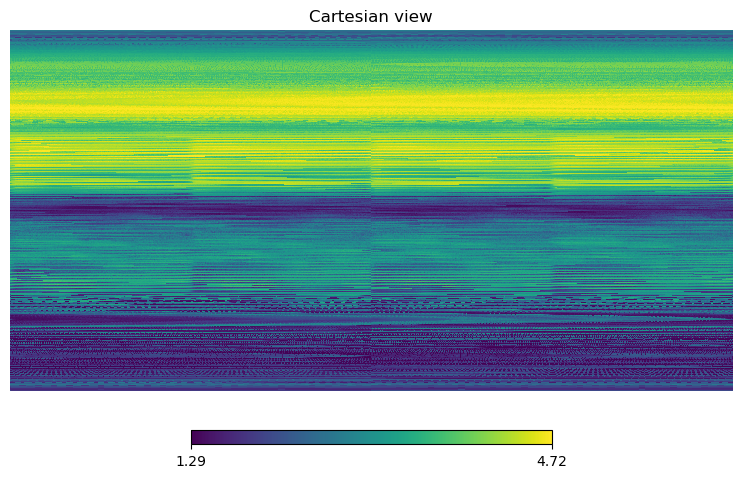

In [43]:
hp.cartview(Q_deconv_flat, norm='hist')

### Go back to fgbuster element

In [44]:
# devo ritornare ad avere elementi del tipo (1, 3, n_pix)
# devo riunire le 3 componenti e aggiungere la prima dimensione

In [45]:
# riunisco le 3 componenti e ottengo un vettore (3, n_pix)
comp_array = np.stack([I_deconv_flat, Q_deconv_flat, U_deconv_flat])

# aggiungo la prima dimensione che essendo 1 non ha bisogno di altre informazioni
comp_array_reshaped = comp_array.reshape((1, 3, 480000))

np.shape(comp_array_reshaped)

(1, 3, 480000)

### Components separation

In [46]:
# define what I fit for
instrument = get_instrument('LiteBIRD')
components = [CMB(), Dust(350.), Synchrotron(40.)]

In [47]:
result = basic_comp_sep(components, instrument, comp_array_reshaped)

print(result.params)
print(result.x)

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']
[ 1.54 20.   -3.  ]


In [48]:
cmb  = result.s[0,1]
dust = result.s[1,1]
sync = result.s[2,1]

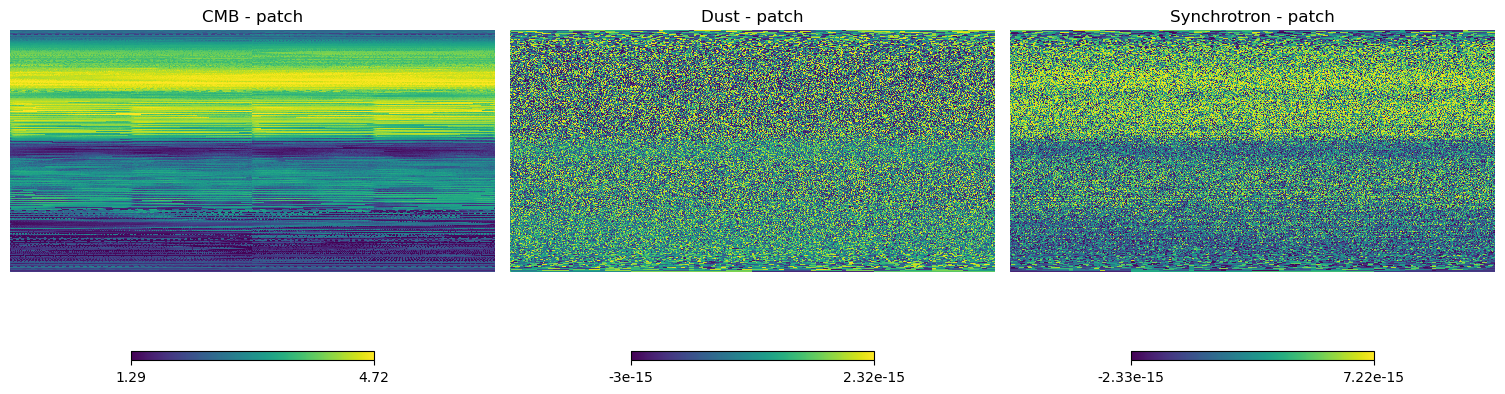

In [49]:
plt.figure(figsize=(15, 10))

hp.cartview(cmb , norm='hist', sub=(1, 3, 1), title='CMB - patch')
hp.cartview(dust, norm='hist', sub=(1, 3, 2), title='Dust - patch')
hp.cartview(sync, norm='hist', sub=(1, 3, 3), title='Synchrotron - patch')